In [55]:
from __future__ import division
from collections import Counter
import csv
import numpy as np
from numpy import arange
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from imblearn.over_sampling import SMOTE

In [2]:
%matplotlib inline

In [3]:
%load_ext watermark

In [4]:
%watermark -a "Ranbir Dixit" -d -v -m -p numpy,scipy,pandas,matplotlib,seaborn,scikit-learn

Ranbir Dixit 2016-08-15 

CPython 2.7.12
IPython 5.0.0

numpy 1.11.1
scipy 0.18.0
pandas 0.18.1
matplotlib 1.5.1
seaborn 0.7.1
scikit-learn 0.17.1

compiler   : MSC v.1500 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 42 Stepping 7, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [5]:
df=pd.read_csv(r'C:\Users\x\OneDrive - University of Stirling\IceRobotics\Data\01_08\hourly interval_28_07_2hrs.csv')

# Answering the Question
The objective is to predict whether a prepartum dairy cow is in the calving stage at different time blocks prior to calving. The time blocks to be tested are -2hrs, -4hrs and -8hrs. As such this problem can be considered as a time-series classification problem.

## Metric's for success:
The main metric for success is the accuracy of the model. A prediction of 80% based on scientific research in the field as well as a previous study by an IceRobotics placement set this as the marker. Additional measures are sensitivity, specificity, positive predictive value and negative predictive value.Specificity of 99% and sensitivity of 80% was defined as the acceptable minimum (ISO, 2007; Borchers, 2015). Minimizing missed calving events (False Negatives) was considered to be more important than minimizing wrongly identified calving events (False Positives) and as such sensitivity accuracy was key.
## Experimental Design
Calving data was obtained from Harper Adam's University, this data consisted of Cow IDs with their associated calving dates and times. This information was then aggregated with sensor data obtained from the database. The data was cleaned and transformed and in its cleaned state consists of 3 days of data sampled at 15 minutes with 34 cows. 31 of these cows have 3 sensors attacched (BL, BR, FL), 2 have 2 sensors attached(BL and BR) and 1 has one sensor attached (FL), for a total of 98 sensors.Classification labels of Calving (C) and Not Calving(NC) were added to the data. Calving labels were added 2 hrs prior to the hour of calving with all other labels set as NC.Therefore across the 72 hour data period, 2/72 labels were set as C and 70/72 labels were set as NC.
## Model generalizability
Even though the data was obtained from one farm, it is assumed that farm management practices are similar in majority of the farms that the company has business with and as such the behaviour of dairy cattle on this farm should generalize well to other farms of a similar design. In addition the data included cows of different parities and locomotion scores, which helps to generalize the findings further.
## Intergation into production environment
Once the models have been built, they will need to be serialized using something similar to python's pickle data format. This way the model can be intergrated into the production environment without having to retrain it each time. Data to be classified will be pulled from an SQL database that contains sensor values, these will then need to be checked for missing data. If the data is missing it will need to be imputed. In addition two new metrics will need to be calculated from the sensor data i.e. lying bouts/hr and the $$activity index=\frac{steps/hr}{standing time/hr}lying bouts/hr^2$$ 

In [6]:
#check dataframe
df.head()

,subject,start,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index,calving
0,112BL,16/08/2015 00:00,0,0,881,2719,0,0,0,NC
1,112BL,16/08/2015 01:00,54,13,1175,2425,2,1,40,NC
2,112BL,16/08/2015 02:00,33,9,428,3172,2,1,76,NC
3,112BL,16/08/2015 03:00,19,4,341,3259,2,1,42,NC
4,112BL,16/08/2015 04:00,7,1,739,2861,1,0,0,NC


In [7]:
#create a cow id column to use for splitting the data into test and train sets
df['cow_id']=df.subject.str.slice(stop=-2)

In [8]:
df.describe()

,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index
count,7056.000000,7056.000000,7056.000000,7056.000000,7056.000000,7056.000000,7056.000000
mean,146.892290,39.193594,1793.034439,1794.465561,1.272817,0.634354,108.938492
std,223.630571,64.710003,1330.526078,1328.462138,1.427374,0.788168,698.725473
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,4.000000,474.000000,431.750000,0.000000,0.000000,0.000000
50%,91.000000,22.000000,1753.500000,1829.000000,1.000000,1.000000,0.000000
75%,184.000000,50.000000,3152.250000,3097.000000,2.000000,1.000000,56.000000
max,3457.000000,1054.000000,3600.000000,3600.000000,17.000000,9.000000,22500.000000


In [9]:
#check for the unique number of cows in the dataset - should be 34
assert len(df.cow_id.unique())==34

In [10]:
#check that the number of sensors/subjects is equal to 98
assert len(df.subject.unique())==98

In [11]:
#check that the number of rows is equal to 7056 - 3 days * 24 readings/day * 98 sensors in total
assert df.shape[0]==7056

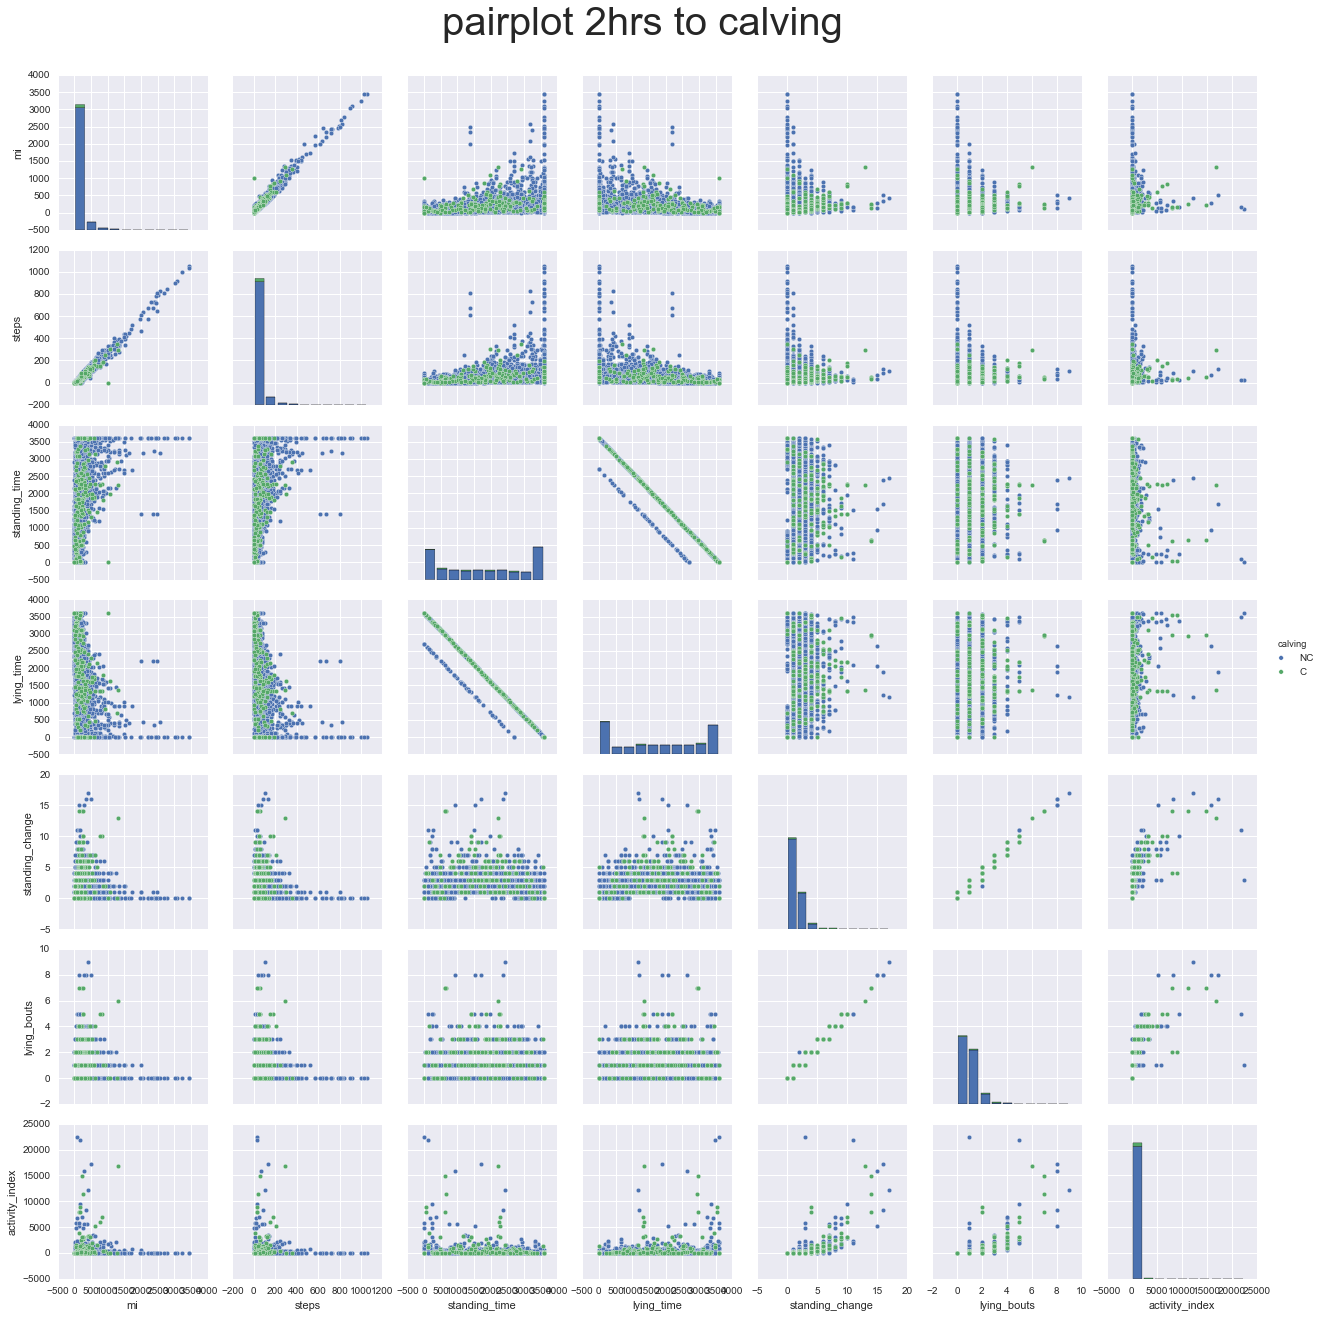

In [12]:
#plotting a scatter plot to visualize the interaction of attributes in the dataframe - are they seperable?
df_plot=df.drop(['subject','start','cow_id'],axis=1)
sns_plot=sns.pairplot(df_plot,hue='calving')
sns_plot.fig.text(0.33,1.02,'pairplot 2hrs to calving',fontsize=40)
sns_plot.savefig('pairplot_2hr.png')

C:\Anaconda2\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


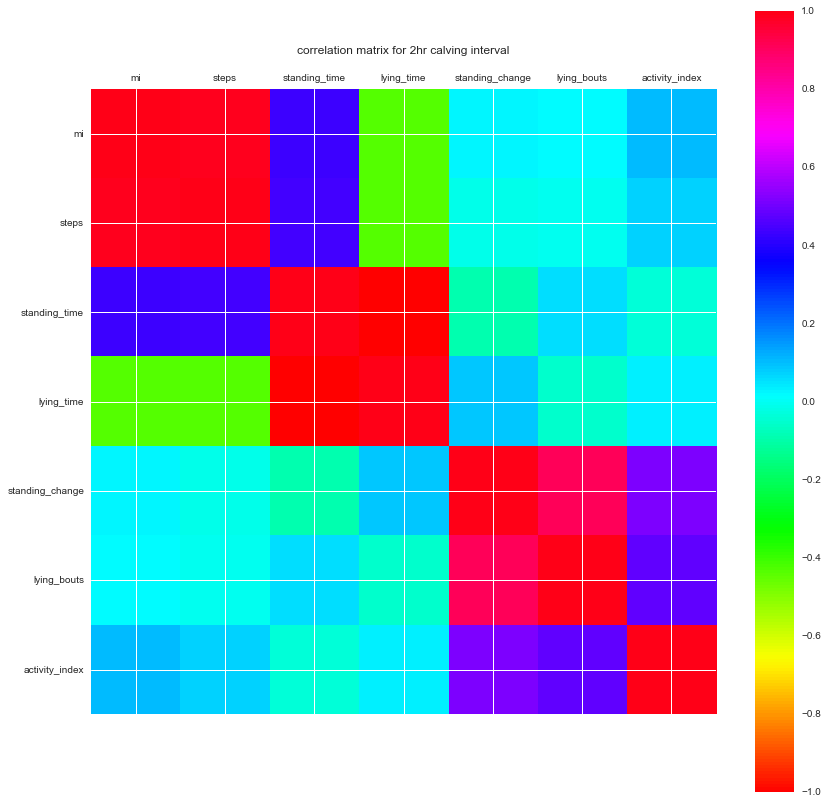

In [13]:
#Correlation Matrix Plot
names=df_plot.columns.values
correlations=df_plot.corr()
#plot correlation matrix
fig=plt.figure(figsize=(14,14))
ax=fig.add_subplot(111)
cax=ax.matshow(correlations,vmin=-1,vmax=1,cmap=plt.cm.hsv)
plt.colorbar(cax)
ticks=np.arange(0,7,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
ax.set_title('correlation matrix for 2hr calving interval')
fig.show()
fig.savefig('2hr_correlation_matrix.png')

In [14]:
correlations

,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index
mi,1.000000,0.986288,0.437432,-0.435317,0.023838,0.023164,0.101599
steps,0.986288,1.000000,0.438164,-0.436563,-0.013090,-0.006541,0.075919
standing_time,0.437432,0.438164,1.000000,-0.996863,-0.086130,0.054993,-0.032235
lying_time,-0.435317,-0.436563,-0.996863,1.000000,0.089408,-0.051769,0.033466
standing_change,0.023838,-0.013090,-0.086130,0.089408,1.000000,0.907637,0.522697
lying_bouts,0.023164,-0.006541,0.054993,-0.051769,0.907637,1.000000,0.479604
activity_index,0.101599,0.075919,-0.032235,0.033466,0.522697,0.479604,1.000000


In [23]:
#feature selection using random forests
feat_labels=df_BL.columns[:-1]
forest=RandomForestClassifier(n_estimators=10000,random_state=0,n_jobs=-1)
forest.fit(X_train_2,y_train_2)
importances=forest.feature_importances_
indices=np.argsort(importances)[::-1]
for f in range(X_train_2.shape[1]):
    print "%2d %-*s %f"%(f+1,30,feat_labels[indices[f]],importances[indices[f]])

 1 mi                             0.206608
 2 activity_index                 0.178937
 3 lying_time                     0.157524
 4 standing_time                  0.157508
 5 steps                          0.156287
 6 standing_change                0.096233
 7 lying_bouts                    0.046904


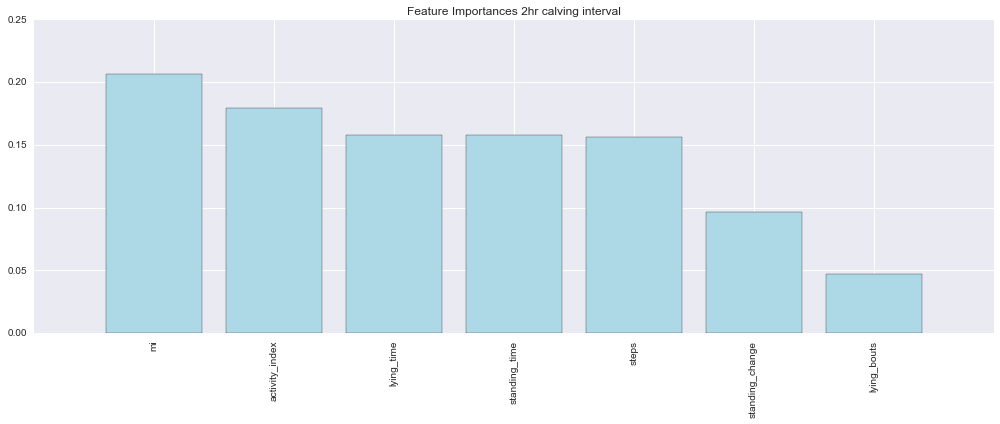

In [24]:
#plot the selection of features
plt.figure(figsize=(14,6))
plt.title('Feature Importances 2hr calving interval')
plt.bar(range(X_train_2.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train_2.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train_2.shape[1]])
plt.tight_layout()
plt.savefig('random_forest_2hr_interval.png')
plt.show()

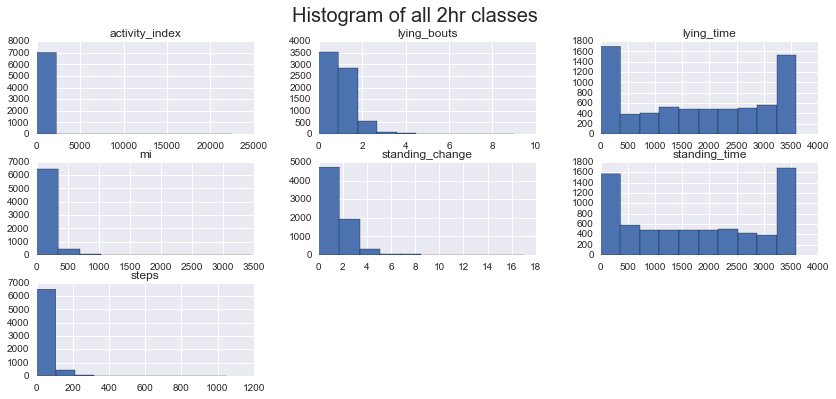

In [25]:
#plot histograms to understand the distribution of attributes
df_plot.hist(figsize=(14,6))
plt.suptitle('Histogram of all 2hr classes',fontsize=20)
plt.savefig('histogram_2h_all_classes')

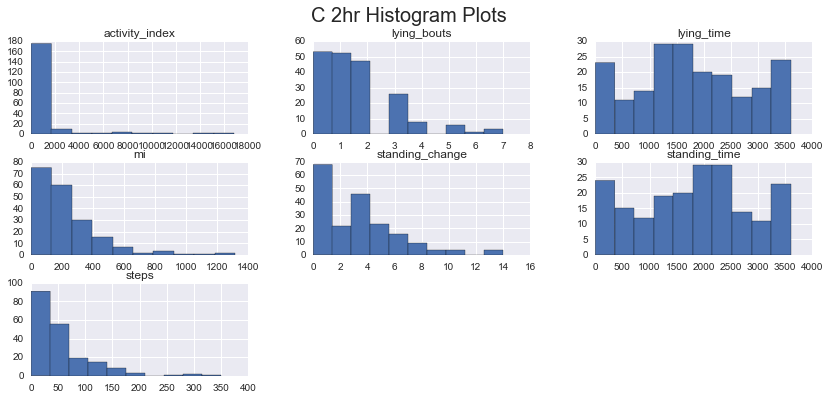

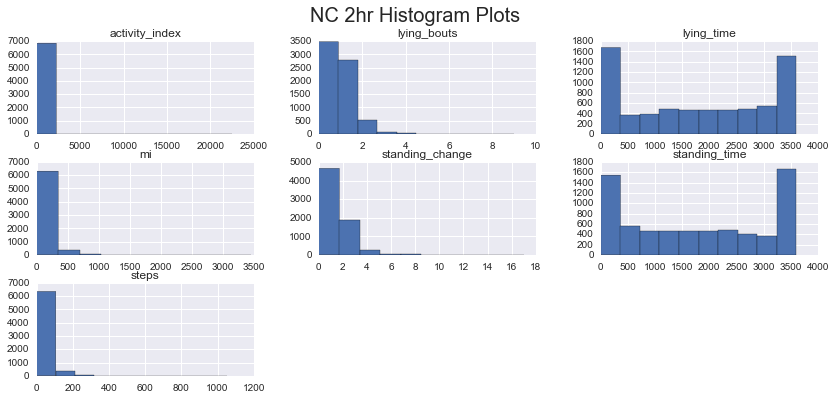

In [26]:
#plot histograms by class to see the distributions within the class
for i,group in df_plot.groupby('calving'):
    group.hist(figsize=(14,6))
    plt.suptitle(str(i)+" 2hr Histogram Plots", fontsize=20)
    plt.savefig(str(i)+' 2hr grouped histogram plots.png')

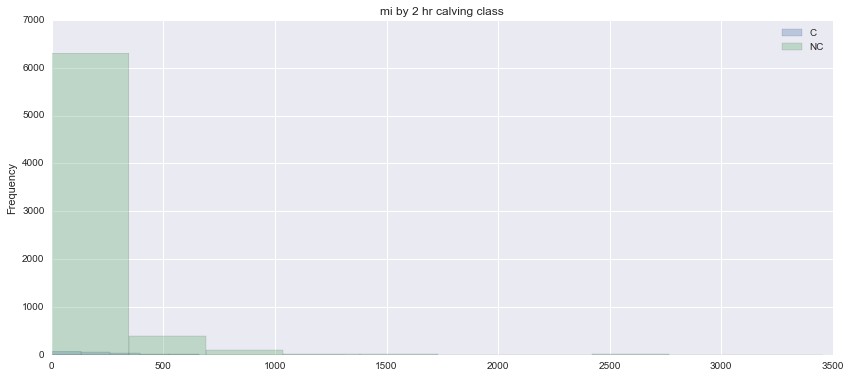

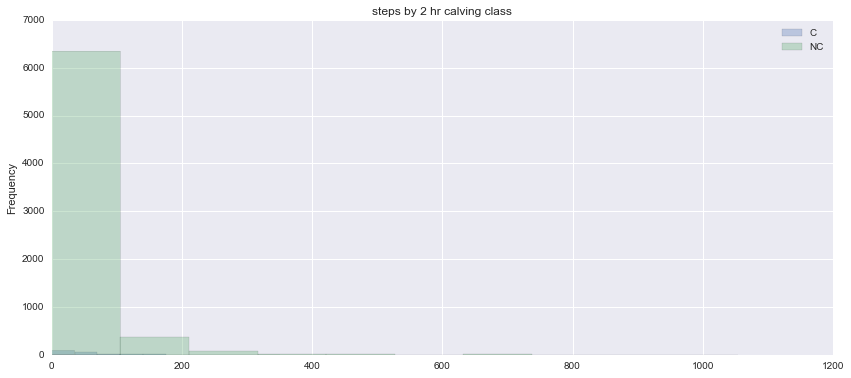

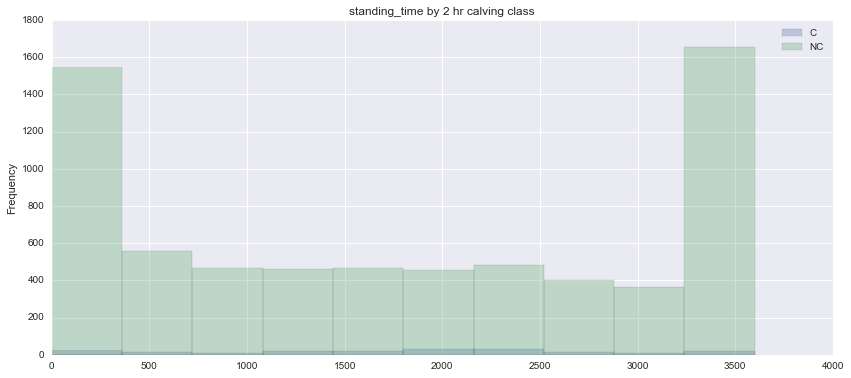

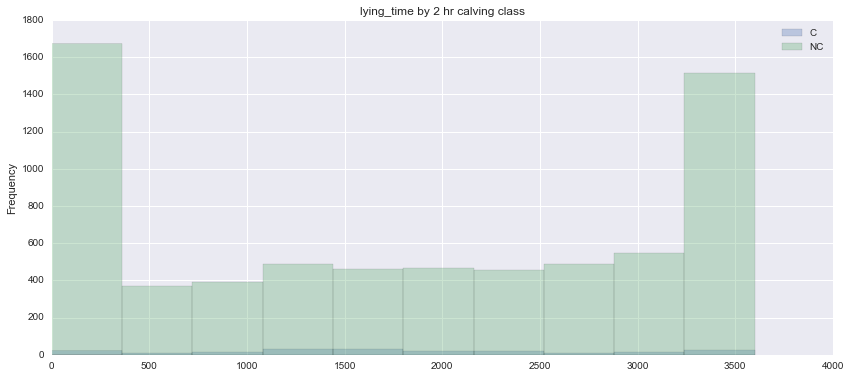

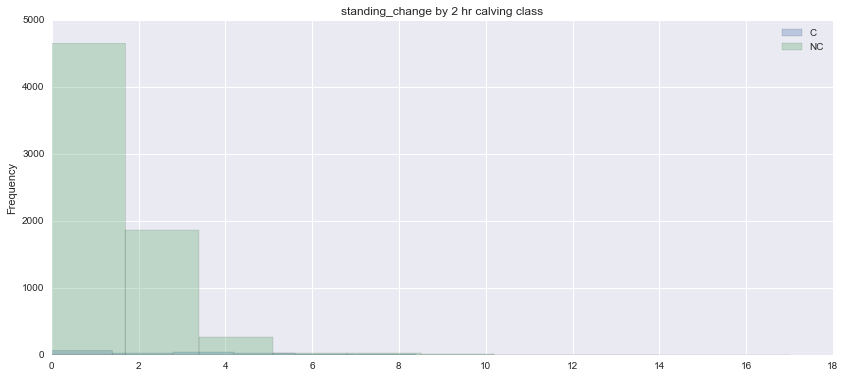

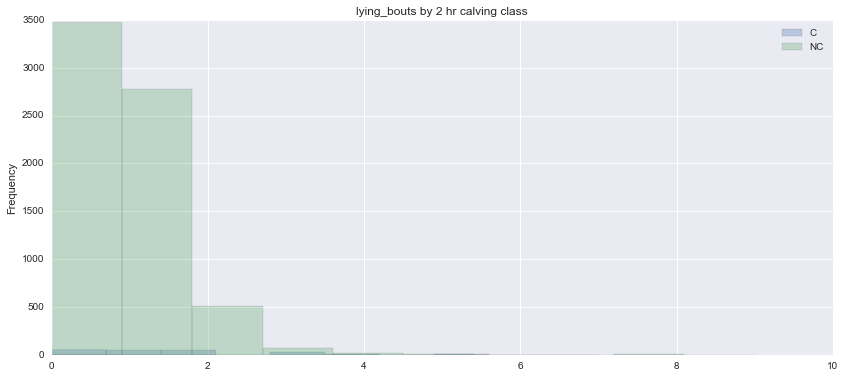

In [27]:
#overlay plot to compare distributions by attributes - data imbalance obscures class - C
for group in df_plot.columns[:-2]:
    plt.figure(figsize=(14,6))
    df_plot.groupby("calving")[group].plot(kind='hist',alpha=0.3,title=str(group) + ' by 2 hr calving class',legend = True,)
    plt.savefig(str(group) + ' by 2 hr calving class.png')

Calving Instances: 2.78 pct
Non-Calving Instances: 97.22 pct


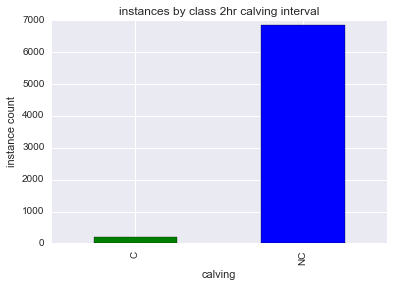

In [28]:
#percentage of instances by type in dataset
calving_inst = df_plot[df_plot['calving']=='C'].count(axis=0)[0]
non_calving_inst=df_plot[df_plot['calving']=='NC'].count(axis=0)[0]
total_inst=calving_inst+non_calving_inst
print "Calving Instances: %.2f pct"%(calving_inst/total_inst*100)
print "Non-Calving Instances: %.2f pct"%(non_calving_inst/total_inst*100)
calving_group=df_plot.groupby('calving')
calving_group_total=calving_group.count()
calving_group_total.mi.plot(kind='bar',title='instances by class 2hr calving interval',color=['g','b'])
plt.ylabel('instance count')
plt.savefig('instances by class 2hr calving interval.png')

### Experiment 1: Splitting the dataframe into a training and test set based on sensor BL
The expriment is used to test a base case scenario where only BL sensors are considered for modelling purposes. 

##### Advantage: maintains the purity of carrying out testing based on a sensor placement that is available on all animals in most farms, including HarperAdams.

##### Disadvantage: reduces the dataset available for modelling from a potential 7056 instances across 3 days to 2448 instances.

In [29]:
#create a data set with just the BL sensors
df['sensor_id']=df.subject.str.slice(start=-2)

In [30]:
#setup a new dataframe that contains only 'BL' sensors
df_BL=df[df['sensor_id']=='BL']

In [31]:
#check that the number of rows is equal to 2448 - 34 cows* 3 days * 24 readings/day 
assert df_BL.shape[0]==2448

In [32]:
#check the attributes
df_BL.head()

,subject,start,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index,calving,cow_id,sensor_id
0,112BL,16/08/2015 00:00,0,0,881,2719,0,0,0,NC,112,BL
1,112BL,16/08/2015 01:00,54,13,1175,2425,2,1,40,NC,112,BL
2,112BL,16/08/2015 02:00,33,9,428,3172,2,1,76,NC,112,BL
3,112BL,16/08/2015 03:00,19,4,341,3259,2,1,42,NC,112,BL
4,112BL,16/08/2015 04:00,7,1,739,2861,1,0,0,NC,112,BL


In [33]:
#drop the attributes that are flat and wide - subject, start,cow_id,sensor_id
df_BL.drop(['subject','start','cow_id','sensor_id'],axis=1,inplace=True)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [34]:
df_BL.head()

,mi,steps,standing_time,lying_time,standing_change,lying_bouts,activity_index,calving
0,0,0,881,2719,0,0,0,NC
1,54,13,1175,2425,2,1,40,NC
2,33,9,428,3172,2,1,76,NC
3,19,4,341,3259,2,1,42,NC
4,7,1,739,2861,1,0,0,NC


In [35]:
#split out the validation set from df_BL
encoder=LabelEncoder()
array=df_BL.values
X=array[:,0:7]
Y=array[:,7]
encoder.fit(Y)
encoded_Y=encoder.transform(Y)
validation_size=0.2
seed=7 #fixed to allow comparison across different models
X_train_2,X_validation_2,y_train_2,y_validation_2 = cross_validation.train_test_split(X,encoded_Y,test_size=validation_size,random_state=seed)

### correcting class imbalance by using the SMOTE library 

As there is a class imbalance issue given that the minority class (calving) exists in just 2/72 instances within the dataset, the SMOTE library is used to oversample this class to rebalance the classes. This is necessary for the machine learning algorithms to perform optimally. Please see https://github.com/scikit-learn-contrib/imbalanced-learn

In [36]:
#use SMOTE on the training set
verbose=True
ratio='auto'
smote=SMOTE(ratio=ratio,kind='regular')
X_train_2_smote,y_train_2_smote=smote.fit_sample(X_train_2,y_train_2)

In [37]:
#check the X_train_2_smote and y_train_2_smote
print "X_train_2_smote:",X_train_2_smote.shape
print "y_train_2_smote:",y_train_2_smote.shape

X_train_2_smote: (3800L, 7L)
y_train_2_smote: (3800L,)


In [38]:
#check for the count of instances of each class
y_2_smote_class_count=Counter(y_train_2_smote)
y_2_train_class_count=Counter(y_train_2)
#Difference between y_train and y_train_smote
class_diff_2=[y_2_smote_class_count[k]-y_2_train_class_count[k] for k,v in zip(y_2_smote_class_count,y_2_train_class_count)]
print "class count difference Calving: ",class_diff_2[0], "instances added"
print "class count difference Non_Calving:",class_diff_2[1],"instances added"

class count difference Calving:  1842 instances added
class count difference Non_Calving: 0 instances added


In [39]:
#percentage of instances by type in dataset
df_after_smote=pd.DataFrame.from_dict(y_2_smote_class_count,orient='index').reset_index()
df_before_smote=pd.DataFrame.from_dict(y_2_train_class_count,orient='index').reset_index()
df_before_smote=df_before_smote.rename_axis({0:"count"},axis=1)
df_before_smote=df_before_smote.set_index(['index'])
df_after_smote=df_after_smote.rename_axis({0:"count"},axis=1)
df_after_smote=df_after_smote.set_index(['index'])

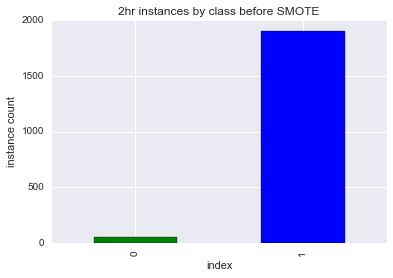

In [40]:
#plot of number of instances by class before SMOTE
plt.figure(figsize=(14,6))
df_before_smote.plot(kind='bar',title='2hr instances by class before SMOTE',color=['g','b'],legend=False)
plt.ylabel('instance count')
plt.savefig('instances by class before SMOTE 2hr calving interval.png')

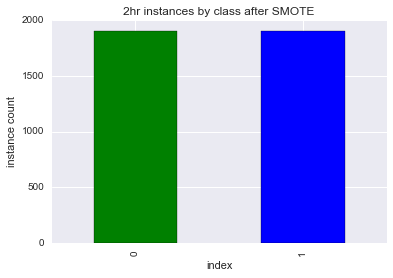

In [41]:
#plot of number of instances by class after SMOTE
plt.figure(figsize=(14,6))
df_after_smote.plot(kind='bar',title='2hr instances by class after SMOTE',color=['g','b'],legend=False)
plt.ylabel('instance count')
plt.savefig('instances by class after SMOTE 2hr calving interval.png')

In [42]:
#scale the attributes in the X_train and X_validation splits, useful for gradient descent optimization
sc=StandardScaler()
sc.fit(X_train_2_smote)
X_train_2_smote_std=sc.transform(X_train_2_smote)
X_validation_2_std=sc.transform(X_validation_2)

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
#test options and evaluation metric
num_folds=10
num_instances=len(X_train_2_smote_std)
seed=7
scoring='accuracy'

In [44]:
#spot check the algorithms
#Algorithms - logisticregression,lineardiscriminantanalysis,knn,classification and regression trees(CART),Gaussian Naive Bayes(NB),Support Vector Machines(SVM), Perceptron
models=[]
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('PPN',Perceptron()))
#evaluate each model in turn
results=[]
names=[]
for name,model in models:
    kfold=cross_validation.KFold(n=num_instances,n_folds=num_folds,random_state=seed)
    cv_results=cross_validation.cross_val_score(model,X_train_2_smote_std,y_train_2_smote,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg='%s: %f (%f)'%(name,cv_results.mean(),cv_results.std())
    print msg

LR: 0.742632 (0.052931)
LDA: 0.732105 (0.074959)
KNN: 0.914474 (0.035448)
CART: 0.942632 (0.016384)
NB: 0.664474 (0.243159)
SVM: 0.759211 (0.074286)
PPN: 0.617105 (0.171288)


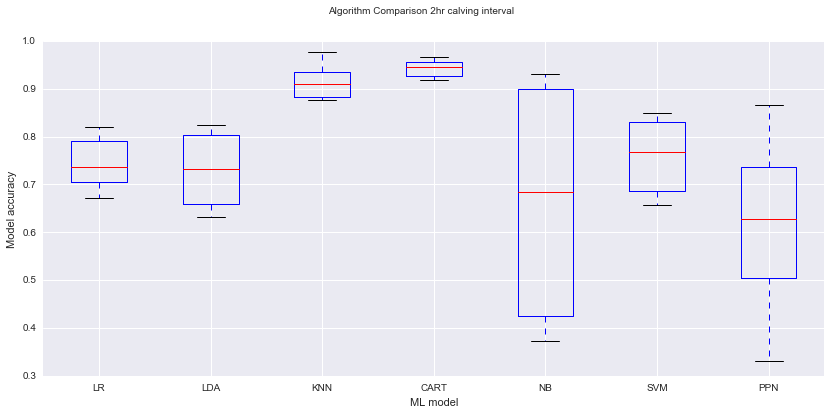

In [45]:
#plots comparing the algorithms
fig=plt.figure(figsize=(14,6))
fig.suptitle('Algorithm Comparison 2hr calving interval')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xlabel('ML model')
plt.ylabel('Model accuracy')
plt.savefig('Algorithm Comparison 2hr calving interval.png')
plt.show()

In [46]:
print "y_train_2_smote:",Counter(y_train_2_smote)
print "y_validation_2:",Counter(y_validation_2)

y_train_2_smote: Counter({0: 1900, 1: 1900})
y_validation_2: Counter({1: 480, 0: 10})


In [47]:
#make predicitions on validation dataset - using knn
knn=KNeighborsClassifier()
knn.fit(X_train_2_smote_std,y_train_2_smote)
predictions=knn.predict(X_validation_2_std)
print "accuracy score:\n",accuracy_score(y_validation_2,predictions)
print  "confusion matrix:\n",confusion_matrix(y_validation_2,predictions)
print "classification report\n:",classification_report(y_validation_2,predictions)

accuracy score:
0.877551020408
confusion matrix:
[[  2   8]
 [ 52 428]]
classification report
:              precision    recall  f1-score   support

          0       0.04      0.20      0.06        10
          1       0.98      0.89      0.93       480

avg / total       0.96      0.88      0.92       490



In [48]:
#make predictions on validation dataset - using CART
cart=DecisionTreeClassifier()
cart.fit(X_train_2_smote_std,y_train_2_smote)
predictions=cart.predict(X_validation_2_std)
print "accuracy score:\n",accuracy_score(y_validation_2,predictions)
print "confusion matrix:\n",confusion_matrix(y_validation_2,predictions)
print "classification report\n:",classification_report(y_validation_2,predictions)

accuracy score:
0.902040816327
confusion matrix:
[[  1   9]
 [ 39 441]]
classification report
:              precision    recall  f1-score   support

          0       0.03      0.10      0.04        10
          1       0.98      0.92      0.95       480

avg / total       0.96      0.90      0.93       490



In [49]:
#make predictions on validation dataset - using PPN
ppn=Perceptron()
ppn.fit(X_train_2_smote_std,y_train_2_smote)
predictions=ppn.predict(X_validation_2_std)
print "accuracy score:\n",accuracy_score(y_validation_2,predictions)
print "confusion matrix:\n",confusion_matrix(y_validation_2,predictions)
print "classification report\n:",classification_report(y_validation_2,predictions)

accuracy score:
0.561224489796
confusion matrix:
[[  4   6]
 [209 271]]
classification report
:              precision    recall  f1-score   support

          0       0.02      0.40      0.04        10
          1       0.98      0.56      0.72       480

avg / total       0.96      0.56      0.70       490



In [50]:
#make predictions on validation dataset - using SVM
svm=SVC()
svm.fit(X_train_2_smote_std,y_train_2_smote)
predictions=svm.predict(X_validation_2_std)
print "accuracy score:\n",accuracy_score(y_validation_2,predictions)
print "confusion matrix:\n",confusion_matrix(y_validation_2,predictions)
print "classification report\n:",classification_report(y_validation_2,predictions)

accuracy score:
0.855102040816
confusion matrix:
[[  2   8]
 [ 63 417]]
classification report
:              precision    recall  f1-score   support

          0       0.03      0.20      0.05        10
          1       0.98      0.87      0.92       480

avg / total       0.96      0.86      0.90       490



### Using a feedforward neural network to try and classify the examples as they are not linearly seperable.

In [70]:
#1.define the network
model=Sequential()
#7 inputs in the visible layer,12 neurons in the hidden layer, rectifier activation function 
model.add(Dense(12,input_dim=7,activation='relu'))
#one neuron in the output layer with a sigmoid activation function
model.add(Dense(1,activation='sigmoid'))
#2. compile the network
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#3. fit the network
history=model.fit(X_train_2_smote_std,y_train_2_smote,nb_epoch=100,batch_size=10,verbose=0)
#4.evaluate the network
loss,accuracy=model.evaluate(X_validation_2_std,y_validation_2)
print "\nLoss: %.2f, Accuracy: %.2f %%"%(loss,accuracy*100)
#5.make predictions
predictions=model.predict(X_validation_2_std)
rounded_predictions=[round(x) for x in predictions]
print "accuracy score:\n",accuracy_score(y_validation_2,rounded_predictions)
print "confusion matrix:\n",confusion_matrix(y_validation_2,rounded_predictions)
print "classification report\n:",classification_report(y_validation_2,rounded_predictions)

352/490 [====================>.........] - ETA: 0s
Loss: 0.45, Accuracy: 83.47 %
accuracy score:
0.834693877551
confusion matrix:
[[  4   6]
 [ 75 405]]
classification report
:              precision    recall  f1-score   support

          0       0.05      0.40      0.09        10
          1       0.99      0.84      0.91       480

avg / total       0.97      0.83      0.89       490



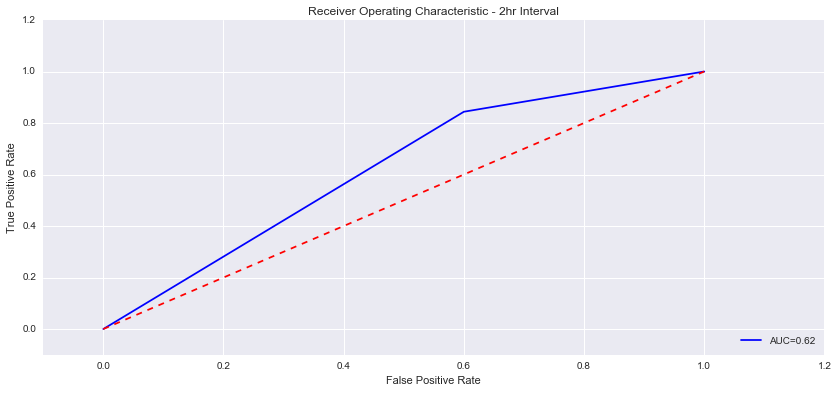

In [71]:
#plot an ROC curve to visualize the difference between the true-positive rate and the false-positive rate
false_pr,true_pr,thresholds=roc_curve(y_validation_2,rounded_predictions)
roc_auc=auc(false_pr,true_pr)
plt.figure(figsize=(14,6))
plt.title('Receiver Operating Characteristic - 2hr Interval')
plt.plot(false_pr,true_pr,'b',label='AUC=%0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('ROC Curve_2hr interval.png')

In [60]:
thresholds

array([ 2.,  1.,  0.])

In [67]:
roc_auc

0.32083333333333336

### Experiment 2: Splitting the dataframe into a training and test set based on the subject attribute
The expriment is used to split up the training and test set so as to preserve the use of all 3 sensors in both sets i.e. sensors BL, BR and FL appear in both the training and test sets respectively. The data is split such that cows in the training set do not appear in the test set and as such prevents confounding of the model accuracy.
##### Advantage: allows the use of the entire dataset for training and testing.



##### Disadvantage:  does not allow the use of cross validation as the training set contains all 3 sensors from each cow and an attempt at cross-validation will result in overfitting

In [ ]:
#split data into training and test-sets
train = 0.67
test = 0.33
#find unique cow_ids
cows_id=df.cow_id.unique()
#select a training sample of unique cow_ids using uniform random sampling without replacement
train=np.random.choice(cows_id,round(train*len(cows_id),0),replace=False)
#filter the df to include only elements in the train set
training_set = df[df.cow_id.isin(train)]
testing_set=df[~df.cow_id.isin(train)]

In [ ]:
#function to split the dataframe into a training and test set
def tt_split(train_split):
    train=train_split
    test=1-train
    #find unique cow ids
    cows_id=df.cow_id.unique()
    #select a training sample of unique cow_ids using uniform random sampling without replacement
    train=np.random.choice(cows_id,round(train*len(cows_id),0),replace=False)
    #filter the df to include only elements in the train set
    training_set = df[df.cow_id.isin(train)]
    testing_set=df[~df.cow_id.isin(train)]
    #drop the training set columns that do not provide any pattern - falt and wide columns
    training_set.drop(['subject','start','cow_id'],axis=1,inplace=True)
    #drop the testing set columns that do not provide any pattern - falt and wide columns
    testing_set.drop(['subject','start','cow_id'],axis=1,inplace=True)
    #split the training-set to X_train,y_train
    X_train = training_set.ix[:,'mi':'activity_index']
    y_train=training_set.ix[:,'calving']
    #split the testing-set to X_test,y_test
    X_test = testing_set.ix[:,'mi':'activity_index']
    y_test=testing_set.ix[:,'calving']
    return X_train,y_train,X_test,y_test

In [ ]:
training_set.describe()

In [ ]:
testing_set.describe()

In [ ]:
#drop the training set columns that do not provide any pattern - falt and wide columns
training_set.drop(['subject','start','cow_id'],axis=1,inplace=True)

In [ ]:
#check the training-set
training_set.shape

In [ ]:
#percentage of instances by type in training set
t_calving_inst = training_set[training_set['calving']=='C'].count(axis=0)[0]
t_non_calving_inst=training_set[training_set['calving']=='NC'].count(axis=0)[0]
t_total_inst=t_calving_inst+t_non_calving_inst
print "Calving Instances: %.2f pct"%(t_calving_inst/t_total_inst*100)
print "Non-Calving Instances: %.2f pct"%(t_non_calving_inst/t_total_inst*100)
t_calving_group=training_set.groupby('calving')
t_calving_group_total=t_calving_group.count()
t_calving_group_total.mi.plot(kind='bar',title='training set instances by class',color=['g','b'])
plt.ylabel('instance count')
plt.savefig('instances by class in training set')

In [ ]:
#drop the testing set columns that do not provide any pattern - falt and wide columns
testing_set.drop(['subject','start','cow_id'],axis=1,inplace=True)

In [ ]:
#check the testing-set
testing_set.shape

In [ ]:
#split the training-set to X_train,y_train
X_train = training_set.ix[:,'mi':'activity_index']
y_train=training_set.ix[:,'calving']

In [ ]:
#check X_train
X_train.head()

In [ ]:
#check y_train
y_train.head()

In [ ]:
#split the testing-set to X_test,y_test
X_test = testing_set.ix[:,'mi':'activity_index']
y_test=testing_set.ix[:,'calving']

In [ ]:
#check X_test
X_test.head()

In [ ]:
#check y_test
y_test.head()

In [ ]:
#check size of X_test and y_test
print "X_test dimension: ",X_test.shape
print "y_test dimension: ", y_test.shape
print "Calving Instances: %.2f %%"%(Counter(y_test)['C']/(Counter(y_test)['C']+Counter(y_test)['NC']))
y_test_df=pd.DataFrame.from_dict(Counter(y_test),orient='index')
y_test_df.rename(columns={'index':'class',0:'counts'},inplace=True)
y_test_df.plot(kind='bar',color=['g','b'],title='class types in test set')
plt.ylabel('instance count')
plt.savefig('class instances in test set')

In [ ]:
#reduce the training dataset class imbalance by oversampling the minority class,C, using SMOTE
def class_balance(X_train,y_train):
    verbose=True
    ratio='auto'
    smote=SMOTE(ratio=ratio,kind='regular')
    X_train_smote,y_train_smote=smote.fit_sample(X_train,y_train)
    return X_train_smote,y_train_smote

In [ ]:
class_balance(X_train,y_train)

In [ ]:
X_train_smote.shape

In [ ]:
y_train_smote.shape

In [ ]:
#check for the count of instances of each class
y_smote_class_count=Counter(y_train_smote)
y_train_class_count=Counter(y_train)
#Difference between y_train and y_train_smote
class_diff=[y_smote_class_count[k]-y_train_class_count[k] for k,v in zip(y_smote_class_count,y_train_class_count)]
print "class count difference Calving: ",class_diff[0], "instances added"
print "class count difference Non_Calving:",class_diff[1],"instances added"

In [ ]:
y_smote_class_df=pd.DataFrame.from_dict(y_smote_class_count,orient='index')
y_smote_class_df.rename(columns={'index':'class',0:'counts'},inplace=True)
y_smote_class_df.plot(kind='bar',color=['g','b'],title='training set instances after SMOTE Oversampling',legend=False)
plt.ylabel('instance count')
plt.savefig('instances in training set after SMOTE Oversampling')

In [ ]:
#scale the attributes in the X_train and X_test splits, useful for gradient descent optimization
def zscore_scaling(X_train_smote,X_test):
    sc=StandardScaler()
    sc.fit(X_train_smote)
    X_train_smote_std=sc.transform(X_train_smote)
    X_test_std=sc.transform(X_test)
    return X_train_smote_std,X_test_std


In [ ]:
#spot check the algorithms
#Algorithms - logisticregression,lineardiscriminantanalysis,knn,classification and regression trees(CART),Gaussian Naive Bayes(NB),Support Vector Machines(SVM), Perceptron
models=[]
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('PPN',Perceptron()))
#evaluate each model in turn
kfolds=10
for name,model in models:
    results=[]
    for kfold in range(kfolds):
        tt_split(0.67)
        class_balance(X_train,y_train)
        zscore_scaling(X_train_smote,X_test)
        model.fit(X_train_smote_std,y_train_smote)
        y_pred=model.predict(X_test_std)
        results.append(accuracy_score(y_test,y_pred))
    res=np.array(results)
    print '%s: %f (%f)'%(name,res.mean(),res.std())


In [ ]:
#grid search for parameters
fieldnames=['n_iter','eta0','error_rate','acc_score']
gridFile=open('parameters.csv','wb')
gridFileWriter=csv.writer(gridFile)
gridFileWriter.writerow(fieldnames)
def ppn_model(n_iter_param,eta0_param):
    #train using a perceptron model
    ppn=Perceptron(n_iter=n_iter_param,eta0=eta0_param,random_state=0)
    ppn.fit(X_train_smote_std,y_train_smote)
    y_pred=ppn.predict(X_test_std)
    error_rate=(y_test!=y_pred).sum()/y_test.shape[0]
    acc_score=accuracy_score(y_test,y_pred)
    print '\t misclassified samples: %.2f %%'%(error_rate*100)
    print '\t accuracy: %.2f %% \n'%(acc_score*100)
    gridFileWriter.writerow([n_iter_param,eta0_param,error_rate,acc_score])
    
for n_iter_param in range(10,510,10):
    print "n_iter_param: ",n_iter_param
    for eta0_param in arange(0.1,1.1,0.1):
        print "\t eta0_param: ",eta0_param
        ppn_model(n_iter_param,eta0_param)
gridFile.close()